# Solving the maximum margin problem with quadratic programming (QP)

The best QP solver for Python is "cvxopt."

First, let's set up synthetic data with linear separability.

Let's try two 2D Gaussians that are well separated.

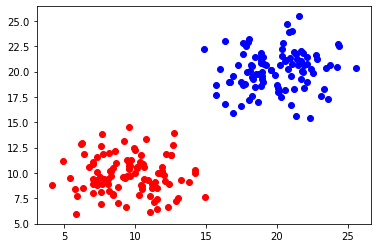

In [1]:
import numpy as np
import cvxopt
import matplotlib.pyplot as plt

# Two 2D Gaussians

mu1 = np.array([10, 10])
mu2 = np.array([20, 20])
sigma = np.array([[4, 0], [0, 4]])

X1 = np.random.multivariate_normal(mu1, sigma, 100)
X2 = np.random.multivariate_normal(mu2, sigma, 100)

plt.plot(X1[:,0], X1[:,1], 'ro')
plt.plot(X2[:,0], X2[:,1], 'bo')
plt.show()


In [3]:
# Combine the classes and set targets

X = np.concatenate((X1, X2), 0)
y = np.concatenate((-np.ones((100, 1)), np.ones((100, 1))), 0)
m = X.shape[0]
n = 2

def cvxopt_solve_qp(Q, c, A=None, b=None, E=None, d=None):
    Q = .5 * (Q + Q.T)  # make sure Q is symmetric
    args = [cvxopt.matrix(Q), cvxopt.matrix(c)]
    if A is not None:
        args.extend([cvxopt.matrix(A), cvxopt.matrix(b)])
        if E is not None:
            args.extend([cvxopt.matrix(E), cvxopt.matrix(d)])
    sol = cvxopt.solvers.qp(*args)
    if 'optimal' not in sol['status']:
        return None
    return np.array(sol['x']).reshape((Q.shape[1],))


In [5]:

# QP problem: set Q, c, A, b

# Parameters are alpha's

# max_alpha [sum of alphas] - 1/2 sum_i,j alpha_i alpha_j y^i y^j <x^i,x^j>
# alpha_i >= 0
# sum alpha_i * y^i = 0

# Set c to give us the sum of the alphas

m = X.shape[0]
c = - np.ones((m, 1))
Q = (y @ y.T) * (X @ X.T)
A = - np.eye(m)
b = np.zeros((m, 1))
E = y.T
d = np.zeros((1, 1))

opt_params = cvxopt_solve_qp(Q, c, A, b, E, d)


     pcost       dcost       gap    pres   dres
 0: -1.5147e+01 -2.6435e+01  5e+02  2e+01  2e+00
 1: -1.5207e+01 -5.2551e+00  1e+02  4e+00  3e-01
 2: -8.4646e+00 -1.3426e+00  6e+01  2e+00  1e-01
 3: -4.8945e-01 -1.2799e-01  2e+00  5e-02  4e-03
 4: -5.8288e-02 -1.1516e-01  6e-02  1e-16  7e-14
 5: -9.0986e-02 -9.7722e-02  7e-03  3e-17  1e-14
 6: -9.6195e-02 -9.6789e-02  6e-04  1e-17  1e-14
 7: -9.6739e-02 -9.6745e-02  6e-06  6e-18  1e-14
 8: -9.6744e-02 -9.6744e-02  6e-08  4e-17  1e-14
Optimal solution found.


In [9]:
print('Alphas that are not zero:', opt_params[opt_params > 1e-5])
print('Corresponding labels:', y[opt_params > 1e-5])
opt_params[opt_params > 1e-5] @ y[opt_params > 1e-5]

Alphas that are not zero: [0.09674418 0.06644038 0.03030376]
Corresponding labels: [[-1.]
 [ 1.]
 [ 1.]]


array([-3.73627861e-08])

In [67]:
def w_b_from_alpha(X, y, alpha):
    S = np.where(alpha > 1e-5)[0]
    alpha_s = alpha[S].reshape(-1,1)
    y_s = y[S]
    X_s = X[S,:]
    w = ((alpha_s * y_s).T @ X_s).T
    b = (y_s - ((alpha_s * y_s).T * (X_s @ X_s.T)).sum(axis=1, keepdims=True)).mean()
    
    # The one-liner for b is equivalent to:
    
    # sum = 0
    # for i in range(len(S)):
    #     sum += y_s[i,0]
    #     for j in range(len(S)):
    #         sum -= alpha_s[j,0] * y_s[j,0] * (X_s[i,:] @ X_s[j,:].T)
    # b = sum / len(S)
    
    return w, b

w, b = w_b_from_alpha(X, y, opt_params)
print('Optimal solution:', w.T, b)

Optimal solution: [[0.36880788 0.2397254 ]] -9.041470762160593


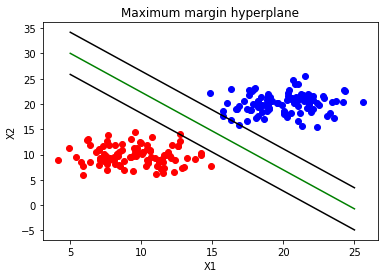

In [64]:
# Line is w^t x + b = 0
# w[0] x11 + w[1] x21 + b = 0
# x21 = (-w[0] x11 - b) / w[1]

x11 = 5
x12 = 25
x21 = (-w[0] * x11 - b) / w[1]
x22 = (-w[0] * x12 - b) / w[1]

plt.plot(X1[:,0], X1[:,1], 'ro')
plt.plot(X2[:,0], X2[:,1], 'bo')
plt.plot((x11, x12), (x21, x22), 'g-')

# Blue margin line

x21 = (-w[0] * x11 - b + 1) / w[1]
x22 = (-w[0] * x12 - b + 1) / w[1]

plt.plot((x11, x12), (x21, x22), 'k-')

# Red margin line

x21 = (-w[0] * x11 - b - 1) / w[1]
x22 = (-w[0] * x12 - b - 1) / w[1]

plt.plot((x11, x12), (x21, x22), 'k-')

plt.title('Maximum margin hyperplane')
plt.xlabel('X1')
plt.ylabel('X2')

plt.show()